In [1]:
import pandas as pd
import numpy as np

In [2]:
fill_df = pd.read_csv("fullMnist.csv", index_col=0)

In [276]:
class TimsLDAClassifier:

    def __init__(self, df: pd.DataFrame):
        # td is training data
        self.td = df
        self.classes = np.sort(self.td.label.unique()).tolist()
        self.num_samples, self.sample_size = self.td.shape
        # subtract 1 from sample size to not count label
        self.sample_size -= 1

    def sortDataByClass(self):
        self.td = self.td.sort_values(by=['label'])

    def buildClassMeans(self):        
        # Allocate array with the correct size - (sample_size) x classes
        self.means = np.zeros(shape=(len(self.classes), self.sample_size)) 
        for clazz in self.classes:
            self.means[self.classes.index(clazz)] = self.meanForClass(clazz)
        
    def meanForClass(self, clazz):
        classSubset = self.td.loc[self.td['label'] == clazz].drop(columns='label').to_numpy()
        classSubset = np.sum(classSubset, axis=0) / classSubset.shape[0]
        return classSubset

    def withinClassCovarianceForClass(self, clazz):
        temp = np.zeros(shape=(self.sample_size, self.sample_size))
        classSubset = self.td.loc[self.td['label'] == clazz].drop(columns='label').to_numpy()
        for row in classSubset:
            curRow = np.subtract(row, self.means[self.classes.index(clazz)])
            curRow = np.dot(np.transpose(classSubset), classSubset)
            temp += curRow
        return temp
        
    def withinClassCovariance(self):
        swCovariance = np.zeros(shape=(self.sample_size, self.sample_size))
        for clazz in self.classes:
            swCovariance += self.withinClassCovarianceForClass(clazz)
        self.sw = swCovariance

    def betweenClassCovariance(self):
        sbCovariance = np.zeros(shape=(self.sample_size, self.sample_size))
        globalMean = np.sum(self.means, axis=0)
        for clazz in self.classes:
            temp = np.subtract(self.means[self.classes.index(clazz)], globalMean)
            temp = np.dot(np.transpose(temp), temp)
            # Scale by the number of samples of this class
            temp = temp * self.td[self.td['label'] == clazz].shape[0]
            sbCovariance += temp
        self.sb = sbCovariance

    def getEigens(self):
        weightMatrix = np.matmul(np.linalg.pinv(self.sw), self.sb)
        self.eigenValues, self.eigenVectors = np.linalg.eig(weightMatrix)
        
            
        

In [269]:
tinySample = fill_df.head(20)

In [280]:
print(testClassifier.eigenVectors.shape)

(784, 784)


In [277]:
testClassifier = TimsLDAClassifier(tinySample)
print(testClassifier.num_samples)
print(testClassifier.sample_size)
testClassifier.buildClassMeans()
testClassifier.withinClassCovariance()
testClassifier.betweenClassCovariance()
testClassifier.getEigens()

20
784


In [225]:
print(type(testClassifier.classes))

<class 'list'>


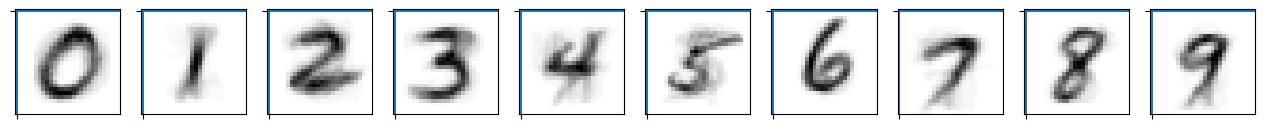

In [206]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

tinySample2 = testClassifier.meanForClass(3)
# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 10
plt.figure(figsize=(16, 6))
for i in range(0, sample_size):
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.imshow(testClassifier.means[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()